# Statistics Crash Course
### 1-2 hours

This tutorial is meant to only cover basic topics encountered in a large fraction of data analysis. These would include:

1. probability distribution functions
2. Central Limit Theorem
3. summarizing data that are normally distributed
4. $\chi^2$ tests and probability-to-exceed (PTE)
5. inverse transform sampling
6. Bayesian inference: likelihoods, priors and posteriors
7. sampling with MCMC

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import print_function
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

Measured quantities are always uncertain. When dealing with data, it is useful to think of any given measurement as being a sample randomly obtained from a *distribution*, where the shape of the distribution determines how much more likely different values are relative to each other. For example, let's look at the **exponential** distribution.

$$ P(x;\mu,\lambda) = \begin{cases}
\lambda e^{-\lambda (x-\mu)} & x \ge \mu, \\
0 & x < \mu.
\end{cases} $$


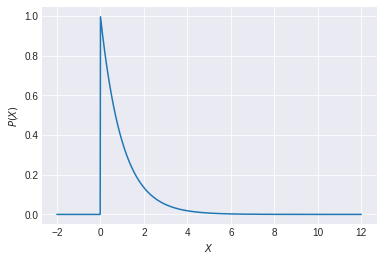

In [3]:
xs = np.linspace(-2,12.,1000)
exs = stats.expon.pdf(xs,loc=0,scale=1)
plt.plot(xs,exs)
plt.xlabel('$X$')
plt.ylabel('$P(X)$')
plt.show()

The notation $P(X)$ reads as probability of $X$, but since $X$ can take continuous values, any given exact value is infinitisimally likely because there are infinitely many real numbers. But what is a finite number is the probability within some specified range. If $P(X)$ is normalized (as in the case of the above exponential distribution) such that its integral over all real numbers is $1$, then

$$
\int_a^b dx P(x)
$$

is the probability (from 0 to 1) that a measurement that is sampled from that distribution will lie in the range $a < x < b$. $P(x)$ is then called the **probability density function**.

Let's use `scipy` to generate samples from the exponential distribution.

In [4]:
data = np.random.exponential(1,size=100000)
print(data[:10])

[0.61573844 0.96228964 2.64266873 0.01481111 1.22033122 0.09483317
 1.09370662 0.13288348 0.60934072 0.9812798 ]


It looks like it is generating numbers close to zero as expected. To visualize what the distribution of the data looks like, it's very useful to *histogram* it, i.e., count the number of instances of the data in small intervals of the data called *bins*. If the histogram is normalized such that the area under it adds to 1 (`density=True`), then it really just ends up being a noisy coarse-grained view of the underlying PDF, which we overplot.

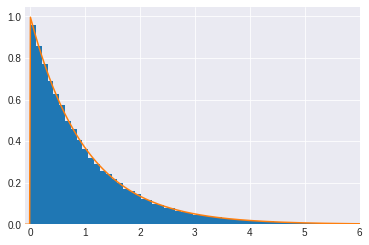

In [5]:
plt.hist(data,bins=100,density=True)
plt.plot(xs,exs)
plt.xlim(-0.1,6)
plt.show()

What if we generated a handful of samples, say, $M$ of them and then averaged them, and then repeated this $N$ times and looked at the distribution of the $N$ averages. For $M=1$, we are just doing the same exercise as above, so we see the exponential distribution. But amazingly, as we bump $M$ up, the distribution looks more and more like a *normal* distribution.

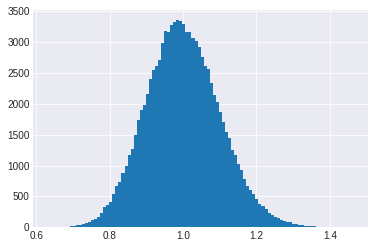

In [10]:
M = 100
N = 100000
data = np.random.exponential(1,size=(M,N))
data_means = data.mean(axis=0)
plt.hist(data_means,bins=100)
plt.show()

This is a manifestation of the **Central Limit Theorem** (CLT). Textbooks often phrase this as "the distribution of the sample mean approaches a normal distribution as the sample size tends to infinity". The CLT is both deep and simple at the same time. The crux of the CLT is that it doesn't matter whether an individual physical process generates samples that are distributed according to some crazy non-Gaussian PDF. If at some point along the line, a reasonable number of these samples undergo some kind of addition (or averaging) procedure, then the distribution of those averaged quantities is very well approximated by a Gaussian (normal) distribution. 

Luckily, many physical measurements have undergone some kind of averaging, so a normal distribution is very often a good approximation. Sometimes, some of that averaging is done by the analyst themselves, by *binning* the data. 

# $\chi^2$ tests

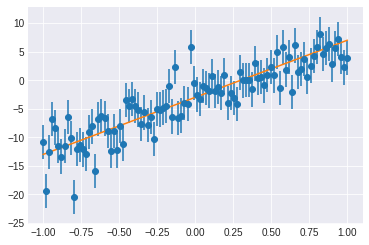

In [15]:

num_data = 100
true_m = 10.0
true_b = -3
noise_scale = 3.0

def simulate_linear_data(num_data,true_m,true_b,noise_scale):
    x = np.linspace(-1,1,num_data)
    yfunc = lambda x: true_m * x + true_b
    y = yfunc(x)
    if noise_scale>1e-10: 
        noise = np.random.normal(0.,noise_scale,size=num_data)
        y += noise
    return x,y

x,y = simulate_linear_data(num_data,true_m,true_b,noise_scale)
xfine,yfine = simulate_linear_data(1000,true_m,true_b,0)
plt.errorbar(x,y,yerr=noise_scale,marker="o",ls="none")
plt.plot(xfine,yfine)
plt.show()

In [16]:
from scipy.stats import chi2

def fit_linear_model(x,y,ycov,funcs,dofs=None):
    """
    From Hogg et. al. 2010
    Given measurements with known uncertainties, this function fits those to a linear model:
    y'(x) = a0*funcs[0](x) + a1*funcs[1](x) + ...
    and returns the best fit coefficients a0,a1,... and their uncertainties as a covariance matrix
    
    ycov -> C -> covariance of data
    x -> independent variable in model
    y -> measured dependent data for each x
    funcs -> functions of x in the linear model
    dofs -> number of degrees of freedom in chi-square calculation, defaults to len(x)-len(funcs)
    
    A = func(x)
    cov =  (A^T C^-1 A)^-1
    b = A^T C^-1 y
    X = cov^-1 b  are best-fit coefficients of funcs
    cov are (co)variances of best-fit coefficients
    
    residual is difference of data from prediction from best-fit
    residual should be normally distributed
    chisquare is (residual)^2/error^2 ~ -2lnLike
    ~ how sums of squares of normally distributed quantities are distributed
    Exact distribution mapped on to by degrees of freedom
    
    We check if chisquare statistic falls within a reasonable region of the chisquare distribution
    One way to systematically calculate this is to calculate PTE (probability to exceed).
    
    It is the probability that repeated measurements would produce higher chisquares than the currently obtained one and can hence be obtained as 1-chisquare_cdf(obtained_chisquare,dofs) since chisquare_cdf(obtained_chisquare,dofs) is the probability of obtaining chisquares less than obtained_chisquare. If this probability is low, that means this chisquare is already really large! The threshold for deciding low PTE is typically taken to be 0.05 (same as idea as the related p-value threshold for null hypothesis testing). But getting a low PTE < 0.05 doesn't mean something is necessarily wrong! You have to take it in the context of the number of tests you did and the number of opportunities for the PTE to fluctuate low. So if you did a large number of tests, it is perfectly reasonable for 5% of them to have PTE<0.05.
    
    
    """
    C = ycov
    y = y.reshape((y.size,1))
    A = np.zeros((y.size,len(funcs)))
    for i,func in enumerate(funcs):
        A[:,i] = func(x)
    cov = np.linalg.inv(np.dot(A.T,np.linalg.solve(C,A)))
    b = np.dot(A.T,np.linalg.solve(C,y))
    X = np.dot(cov,b)
    YAX = y - np.dot(A,X)
    chisquare = np.dot(YAX.T,np.linalg.solve(C,YAX))
    dofs = len(x)-len(funcs) if dofs is None else dofs
    pte = 1.-chi2.cdf(chisquare, dofs)    
    return X,cov,chisquare,dofs,pte


funcs = [lambda x: 1., lambda x: x]
X,cov,chisquare,dofs,pte = fit_linear_model(x,y,np.diag(x*0.+noise_scale**2.),funcs,dofs=None)

[[86.37353262]]
98


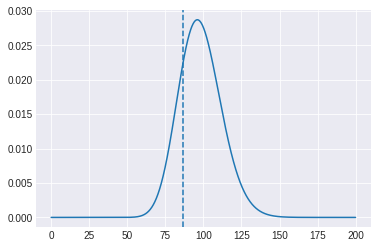

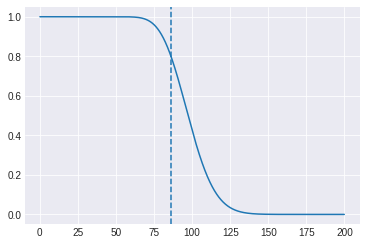

[[0.79322203]]


In [17]:
print(chisquare)
print(dofs)

x2s = np.arange(0,200,0.1)
chis = chi2.pdf(x2s,dofs)
plt.plot(x2s,chis)
plt.axvline(chisquare,ls="--")
plt.show()


ptes = 1-chi2.cdf(x2s, dofs)
plt.plot(x2s,ptes)
plt.axvline(chisquare,ls="--")
plt.show()
print(pte)

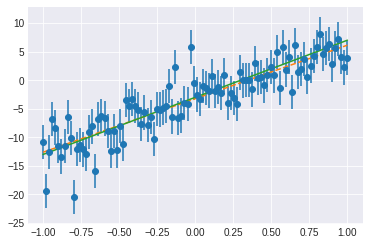

In [18]:
yfit = sum([fx*f(xfine) for f,fx in zip(funcs,X)])
plt.errorbar(x,y,yerr=noise_scale,marker="o",ls="none")
plt.plot(xfine,yfit,ls="--")
plt.plot(xfine,yfine)
plt.show()

In [19]:
# Let's simulate many experiments

Nsims = 30000
ptes = []
for i in range(Nsims):
    x,y = simulate_linear_data(num_data,true_m,true_b,noise_scale)
    X,cov,chisquare,dofs,pte = fit_linear_model(x,y,np.diag(x*0.+noise_scale**2.),funcs,dofs=None)
    ptes.append(pte.ravel()[0])


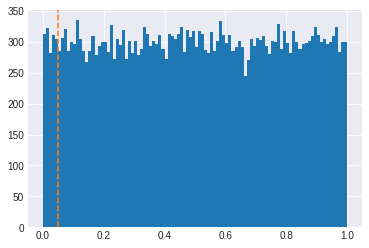

5.09666666667


In [55]:

#PTE < 0.05 happens ~5% of the time!

plt.hist(ptes,bins=100)
plt.axvline(x=0.05,ls="--",color="C1")
plt.show()
ptes = np.array(ptes)
print(ptes[ptes<0.05].size*1./Nsims*100.)

## Inverse Transform Sampling (for low-dimensional parameter spaces)

`numpy` and `scipy` have useful functions if you want to sample from well-known PDFs. What if you wanted to sample from an aribtrary PDF? For low-dimensional parameter spaces, one can use the Inverse Transform technique. Below, we will do this for a weird bimodal 1D PDF constructed from a sum of two normal distributions.

The algorithm (whose proof I will not go in to) is:
1. calculate the cumulative distribution function (CDF)
2. find the inverse $f(x)$ of the CDF 
3. for each desired sample from the target PDF, sample $u$ uniformly from 0 to 1 and return $f(u)$

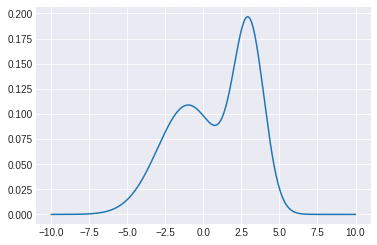

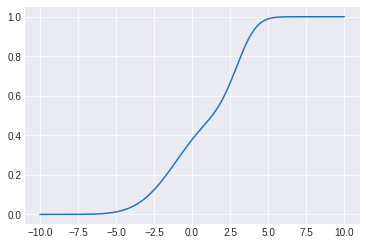

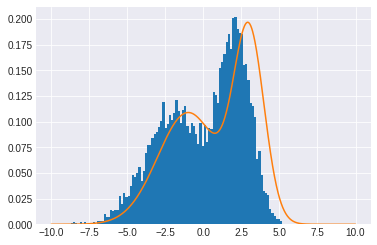

In [2]:
class InverseTransformSampling(object):
    def __init__(self,xvals,pdf_vals):
        dxs = np.diff(xs)
        assert np.all(np.isclose(dxs,dxs[0]))
        norm = np.trapz(pdf_vals,xvals)
        self.xs = xvals
        self.pdf = pdf_vals/norm
        self.expectation = np.trapz(self.pdf*self.xs,self.xs)
        self.cdf = np.cumsum(self.pdf)*dxs[0]
        from scipy.interpolate import interp1d
        self.icdf = interp1d(self.cdf,self.xs)
    def generate(self,size,zero_mean=False):
        return self.icdf(np.random.uniform(0,1,size=size)) - self.expectation*int(zero_mean)


# Our weird PDF
npdf = lambda x: (np.exp(-(x-3)**2/2) + 0.6 * np.exp(-(x+1)**2/2/4))/5.51458
xs = np.linspace(-10,10,1000)

egen = InverseTransformSampling(xs,npdf(xs))

plt.plot(egen.xs,egen.pdf)
plt.show()



plt.plot(egen.xs,egen.cdf)
plt.show()





plt.hist(egen.generate((1,10000),zero_mean=True).mean(axis=0),density=True,bins=100)
plt.plot(xs,npdf(xs))
plt.show()

## Bayesian inference

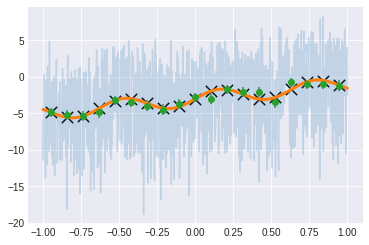

In [3]:
from scipy.stats import binned_statistic

num_bins = 20

def model(x,a,b,c):
    return np.sin(a*x) + b*x +c

def residual_pdf(size):
    return 2*egen.generate(size=size,zero_mean=True)

true_a = 10
true_b = 2
true_c = -3

def generate_data():
    Npoints = 1000
    x = np.linspace(-1,1,Npoints)
    return model(x,true_a,true_b,true_c) + residual_pdf(Npoints)
    
xs = np.linspace(-1,1,1000)
bin_edges = np.linspace(-1,1,num_bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.

true_model_fine = model(xs,true_a,true_b,true_c)
binned_true = binned_statistic(xs,true_model_fine,bins=bin_edges,statistic=np.mean)[0]

data = generate_data()
binned_data = binned_statistic(xs,data,bins=bin_edges,statistic=np.mean)[0]
binned_var = binned_statistic(xs,data,bins=bin_edges,statistic=np.var)[0]
binned_count = binned_statistic(xs,data,bins=bin_edges,statistic=np.size)[0]
binned_sigma = np.sqrt(binned_var/binned_count)

xs = np.linspace(-1,1,1000)
plt.plot(xs,data,alpha=0.2,color="C0")
plt.plot(xs,true_model_fine,color="C1",lw=3)
plt.scatter(bin_centers,binned_true,marker="x",s=128,color='k')
plt.errorbar(bin_centers,binned_data,yerr=binned_sigma,marker="o",color="C2",ls="none")
plt.show()



In [4]:

def lnlike(y,yerr,pars):
    a,b,c = pars
    theory = binned_statistic(xs,model(xs,a,b,c),bins=bin_edges,statistic=np.mean)[0]
    residual = y-theory
    inv_sigma2 = 1.0/(yerr**2.)
    return -0.5*(np.sum((y-theory)**2*inv_sigma2))

def lnprior(pars):
    a,b,c = pars
    if 5 < a < 15 and 0.0 < b < 5 and -5 < c < 0:
        return 0.0
    return -np.inf


def lnprob(pars, y, yerr):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(y, yerr,pars)

In [5]:
ndim, nwalkers = 3, 20
init = (7,1.5,-2)
pos = [init + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [6]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(binned_data, binned_sigma))

In [7]:
chains = sampler.run_mcmc(pos, 3000)

/home/msyriac/.local/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


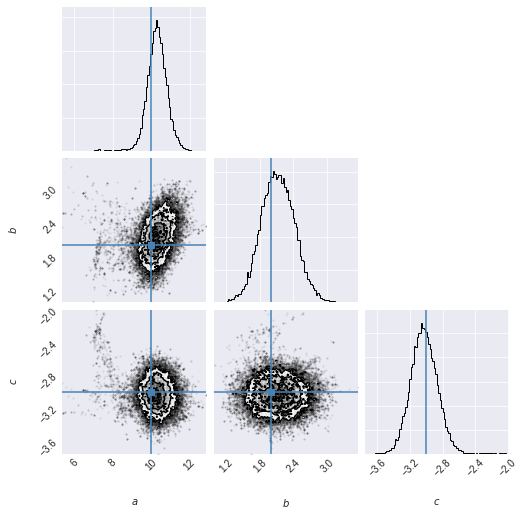

In [8]:

import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$"],
                      truths=[true_a, true_b, true_c],bins=100)
fig.show()

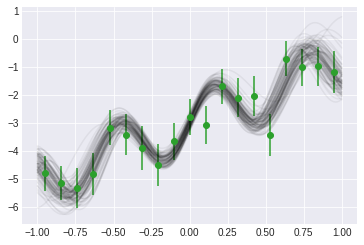

In [9]:
for a, b, c in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xs, model(xs,a,b,c), color="k", alpha=0.05)

plt.errorbar(bin_centers,binned_data,yerr=binned_sigma,marker="o",color="C2",ls="none")
plt.show()

In [10]:
a_mcmc, b_mcmc, c_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [11]:
print(a_mcmc,true_a)
print(b_mcmc,true_b)
print(c_mcmc,true_c)

(10.287225178658371, 0.4914511383201461, 0.48124036560509964) 10
(2.114421107118348, 0.302507519718032, 0.2905575168413246) 2
(-3.0346396976593013, 0.16277120799231515, 0.15306700092815984) -3
